In [23]:
# init

import numpy as np

smplRate = 44100
timeline_duration = 2
timeline = np.zeros(timeline_duration * smplRate, dtype = np.float32)

In [24]:
# make tone

t0 = .0
duration = 0.2
t = np.array( range( int(t0*smplRate) , int((t0+duration)*smplRate) ) , dtype="float") / smplRate
t2p = t * 2 * np.pi

fade_duration = 0.002
fade_size = int(smplRate*fade_duration)
fade_in = np.linspace(0, 1, fade_size, dtype=np.float32)
fade_out = np.linspace(1, 0, fade_size, dtype=np.float32)

def make_tone(fundamental, harmonics_ratios):
    ft2p = fundamental * t2p
    sound = np.sin(ft2p)
    j = 2
    for harmonic_ratio in harmonics_ratios:
        sound += np.sin(ft2p * harmonic_ratio)/j
        j += 2
    sound[:fade_size] *= fade_in
    sound[-fade_size:] *= fade_out
    return sound/10

In [25]:
# set keyboard layout

from pynput import keyboard

keyboard_layout = []
def on_press(key):
    if key == keyboard.Key.esc:
        # Stop listener
        return False
    try:
        keyboard_layout.append(key.char)
    except AttributeError:
        print('special key {0} pressed'.format(
            key))
with keyboard.Listener(on_press=on_press) as listener:
    listener.join()

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


In [28]:
# open audio
import pyaudio

position = 0

def callback(in_data, frame_count, time_info, status):
    # If len(data) is less than requested frame_count, PyAudio automatically
    # assumes the stream is finished, and the stream stops.
    global position
    if timeline.size >= (position + frame_count):
        data = timeline[position:position+frame_count].copy()
        # timeline[position:position+frame_count] = 0
        position += frame_count
    else:
        data = timeline[position:].copy()
        # timeline[position:] = 0
        position += frame_count
        position -= timeline.size
        data = np.append(data, timeline[:position])
        # timeline[:position] = 0
    return (data, pyaudio.paContinue)

paud = pyaudio.PyAudio()
stream = paud.open(
            format=pyaudio.paFloat32,
            channels=1,
            rate=smplRate,
            output=True,
            stream_callback=callback
            )

In [30]:
# listen to keyboard

streams = []
def on_press(key):
    try:
        fundamental = 400 * 2**(keyboard_layout.index(key.char)/12)
    except AttributeError:
        print('special key {0} pressed'.format(
            key))
        return
    global position
    tone = make_tone(fundamental,[2, 3, 4, 5, 6])
    data_size = tone.size
    if timeline.size >= (position + data_size):
        timeline[position:position+data_size] += tone
    else:
        tone.size - timeline.size
        timeline[position:] += tone[:timeline.size-position]
        timeline[:position+tone.size-timeline.size] += tone[timeline.size-position:]
    

def on_release(key):
    if key == keyboard.Key.esc:
        # Stop listener
        stream.close()
        paud.terminate()
        return False

# Collect events until released
with keyboard.Listener(
        on_press=on_press,
        on_release=on_release) as listener:
    listener.join()



# ...or, in a non-blocking fashion:
# listener = keyboard.Listener(
#     on_press=on_press,
#     on_release=on_release)
# listener.start()

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


special key Key.esc pressed


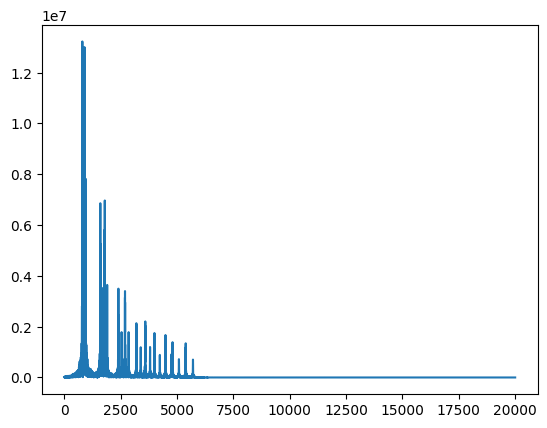

In [22]:
# frequency plot

from scipy.fft import fft
import matplotlib.pyplot as plt

max_amplitude = np.iinfo(np.int16).max
safe_amplitude = int(max_amplitude/2)

plt.plot(np.abs(fft((timeline * safe_amplitude).astype(np.int16))[0:20000]))

In [21]:
# save
import scipy.io.wavfile
scipy.io.wavfile.write("timeline.wav",smplRate,(timeline * safe_amplitude).astype(np.int16))

In [15]:
# closing audio in case of emergency
stream.close()
paud.terminate()

In [29]:
timeline = np.zeros(timeline_duration * smplRate, dtype = np.float32)